### Student Information
Name: 林家銘

Student ID: 111062661

GitHub ID: jeremylin168

Kaggle name: godwhale2000

Kaggle private scoreboard snapshot: 

![Snapshot](pic.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

# Part1

In [1]:
### Begin Assignment Here
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
### training data
anger_train = pd.read_csv("../data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("../data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("../data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("../data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

### testing data
anger_test = pd.read_csv("../data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("../data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("../data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("../data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)

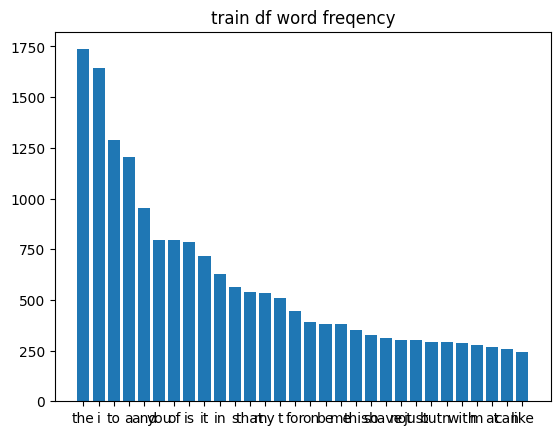

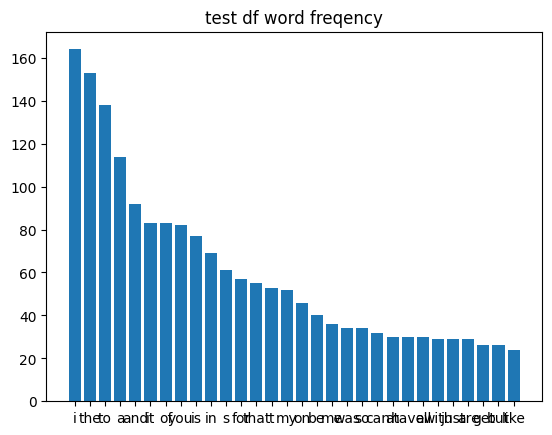

In [3]:
# Answer here
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt

tokenizer = RegexpTokenizer(r'\w+')

#count train df word number
word_count_dict_train = {}

for txt in train_df.text:
    for word in tokenizer.tokenize(txt.lower()):
        if word not in word_count_dict_train.keys():
            word_count_dict_train[word] = 1
        else:
            word_count_dict_train[word] += 1

#count test df word number
word_count_dict_test = {}

for txt in test_df.text:
    for word in tokenizer.tokenize(txt.lower()):
        if word not in word_count_dict_test.keys():
            word_count_dict_test[word] = 1
        else:
            word_count_dict_test[word] += 1

# sort words
sorted_train_word = sorted(word_count_dict_train.items(), key=lambda x: x[1], reverse= True)
sorted_test_word = sorted(word_count_dict_test.items(), key=lambda x: x[1], reverse= True)

# plot word freqency
plt.title('train df word freqency')
plt.bar([i[0] for i in sorted_train_word[:30]], [i[1] for i in sorted_train_word[:30]])

plt.show()

plt.title('test df word freqency')
plt.bar([i[0] for i in sorted_test_word[:30]], [i[1] for i in sorted_test_word[:30]])

plt.show()

---

In [4]:
## save to pickle file
train_df.to_pickle("../train_df.pkl") 
test_df.to_pickle("../test_df.pkl")

In [5]:
## load a pickle file
train_df = pd.read_pickle("../train_df.pkl")
test_df = pd.read_pickle("../test_df.pkl")

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [6]:

"""
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])


# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
"""

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()

c:\Users\jerem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)

tfidf_vectorizer.fit(train_df['text'])

print(tfidf_vectorizer.get_feature_names_out()[100:110])

['awful' 'b' 'baby' 'back' 'bad' 'ball' 'balls' 'bb18' 'bc' 'bday']


---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [8]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

print(classification_report(y_true=y_test, y_pred=y_test_pred))



X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)
training accuracy: 0.99
testing accuracy: 0.68
              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



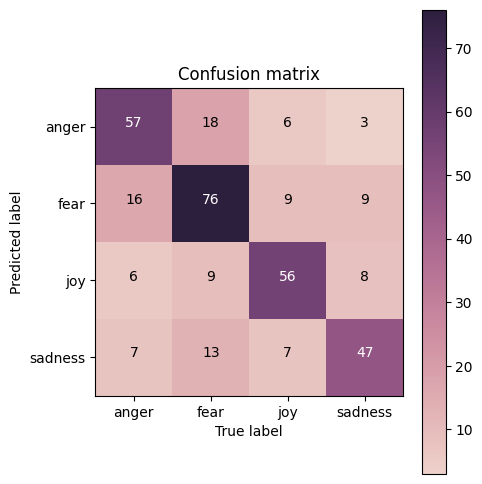

In [9]:
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

In [ ]:
# Answer here
# The number in diagonal of the matrix shows how much data is predicted correctly. For example the anger is classified to the anger. The fear is classified to fear.
# The other blocks in the matrix shows how much data is miss classified.

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

training accuracy: 0.79
testing accuracy: 0.7

classification report
              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347




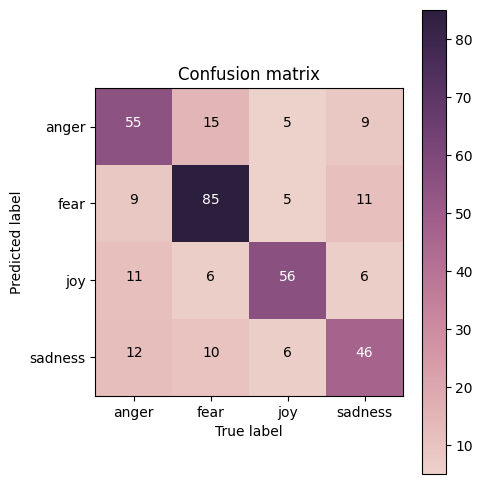

In [10]:
# Train
Multi_NB = MultinomialNB()
Multi_NB.fit(X_train, y_train)

## predict
y_train_pred = Multi_NB.predict(X_train)
y_test_pred = Multi_NB.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 


acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))
print()

print("classification report")
print(classification_report(y_true=y_test, y_pred=y_test_pred))
print()

my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

In [ ]:
# Answer here
# You can find out the training data accuracy of decision tree is nearly 100% and the training data accuracy of Naive Bayes is closer to the testing data accuracy. 
# The reason of the differece of the two model is based on the background theory of two models. The method of decision tree is tried to build a tree to fit all the training data and the method of Navie Bayes is to find the probability of label from the training data features.

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models. 

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

In [11]:
import keras
from sklearn.preprocessing import LabelEncoder

In [25]:
# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [26]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1443    fear
2452     joy
2293     joy
2057     joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


In [27]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


In [28]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_6 (Dense)             (None, 64)                32064     
                                                                 
 re_lu_4 (ReLU)              (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_5 (ReLU)              (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
 softmax_2 (Softmax)         (None, 4)                 0   

In [29]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('../logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25


113/113 [==============================] - 1s 2ms/step - loss: 1.3281 - accuracy: 0.3695 - val_loss: 1.2671 - val_accuracy: 0.4841
Epoch 2/25
113/113 [==============================] - 0s 1ms/step - loss: 1.0143 - accuracy: 0.6358 - val_loss: 0.9126 - val_accuracy: 0.6628
Epoch 3/25
113/113 [==============================] - 0s 1ms/step - loss: 0.6034 - accuracy: 0.7938 - val_loss: 0.7601 - val_accuracy: 0.7003
Epoch 4/25
113/113 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.8472 - val_loss: 0.7876 - val_accuracy: 0.6945
Epoch 5/25
113/113 [==============================] - 0s 1ms/step - loss: 0.3334 - accuracy: 0.8799 - val_loss: 0.8030 - val_accuracy: 0.7118
Epoch 6/25
113/113 [==============================] - 0s 1ms/step - loss: 0.2703 - accuracy: 0.9098 - val_loss: 0.8778 - val_accuracy: 0.6945
Epoch 7/25
113/113 [==============================] - 0s 1ms/step - loss: 0.2218 - accuracy: 0.9258 - val_loss: 0.9183 - val_accuracy: 0.6801
Epoch 8/25
113/11

In [30]:
## predict
pred_result = model.predict(X_test, batch_size=128)

3/3 [==============================] - 0s 2ms/step


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="../pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="../pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

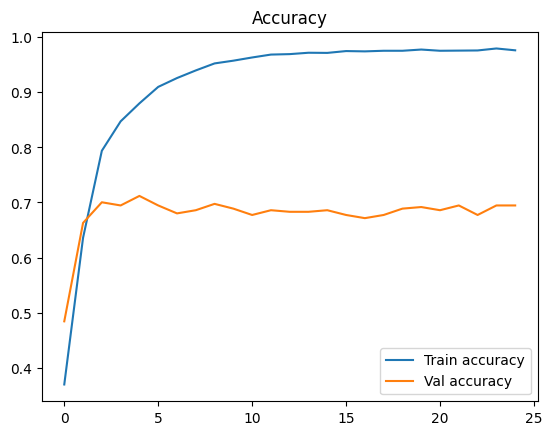

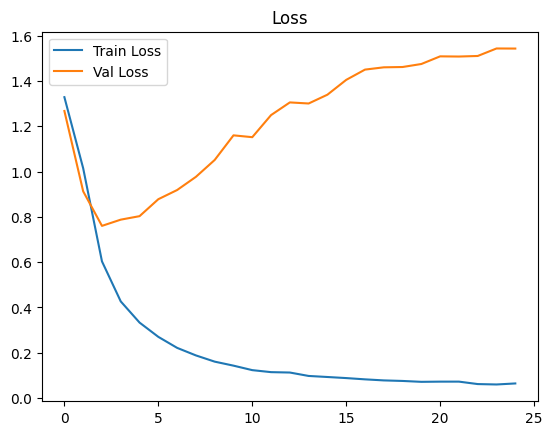

In [31]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("../logs/training_log.csv")

# Answer here
plt.title('Accuracy')
plt.plot(training_log.epoch, training_log.accuracy,  label='Train accuracy')
plt.plot(training_log.epoch, training_log.val_accuracy,  label='Val accuracy')

plt.legend()
plt.show()

plt.title('Loss')
plt.plot(training_log.epoch, training_log.loss,  label='Train Loss')
plt.plot(training_log.epoch, training_log.val_loss,  label='Val Loss')

plt.legend()
plt.show()

In [ ]:
# We can observe the training loss is continually dropping but the validation loss is increasing after epoch 4. It shows that the model is overfitting after epoch 4.

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?

In [ ]:
# Answer here
# We can embedding all the words in the sentence and average all the word vectors to get the sentence vector.


---

In [20]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "../GoogleNews/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

load ok


---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [21]:
# Answer here
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]        
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('angry_words: ', angry_words)
print('happy_words: ', happy_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = angry_words + happy_words + sad_words + fear_words
print('\ntarget words: ')
print(len(target_words))
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
64
['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated',

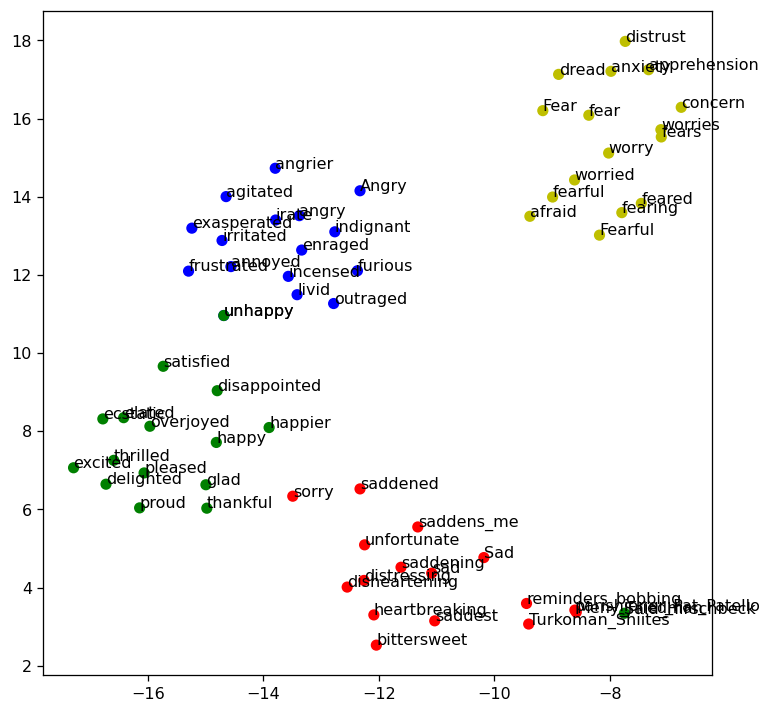

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=66)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

## Part 2

In [1]:
import pandas as pd
import numpy as np
import json
import os
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import ReLU, Softmax
from tensorflow.keras.utils import to_categorical

# google key vectors
from gensim.models import KeyedVectors

# Hide GPU from visible devices
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'



In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
# load stopword
nltk.download('stopwords')
stopw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# preprocessing
# load data
data_id = pd.read_csv("dm2023-isa5810-lab2-homework/data_identification.csv")
data_emo = pd.read_csv("dm2023-isa5810-lab2-homework/emotion.csv")
train_id = data_id[data_id["identification"]=='train']
test_id = data_id[data_id["identification"]=='test']


id2emo = {}
for i in range(len(data_emo)):
    id2emo[data_emo.iloc[i]['tweet_id']] = data_emo.iloc[i]['emotion']

print(id2emo['0x360b99'])
print(test_id)
print(data_emo[data_emo["tweet_id"]=='0x3140b1'])
print(data_id[data_id["tweet_id"]=='0x3140b1'])

fear
         tweet_id identification
0        0x28cc61           test
3        0x2db41f           test
15       0x2466f6           test
23       0x23f9e9           test
31       0x1fb4e1           test
...           ...            ...
1867495  0x2c4dc2           test
1867496  0x31be7c           test
1867500  0x1ca58e           test
1867515  0x35c8ba           test
1867518  0x1d941b           test

[411972 rows x 2 columns]
   tweet_id  emotion
0  0x3140b1  sadness
         tweet_id identification
1209185  0x3140b1          train


In [5]:
print(data_emo.iloc[0])

tweet_id    0x3140b1
emotion      sadness
Name: 0, dtype: object


In [6]:
# create emotion embedding
label_encoder = LabelEncoder()
label_encoder.fit(data_emo["emotion"])

print('check label: ', label_encoder.classes_)
print(label_encoder.transform(['sadness']))

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']
[5]


In [4]:
# preprocessing json data
text_data = {}
with open("dm2023-isa5810-lab2-homework/tweets_DM.json", "r") as f:
    for line in f:
        d = json.loads(line)
        text_data[d['_source']['tweet']['tweet_id']] = d['_source']['tweet']['text']

    
print(len(text_data))

1867535


In [5]:
# load google model
model_path = "../GoogleNews/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

load ok


In [12]:
print(len(w2v_google_model['happy']))

300


In [14]:
# json to word2Vec
wv_data = {}

for tw_id in text_data.keys():
    tp_wv = np.zeros(300)
    wordcount = 0
    
    for word in word_tokenize(text_data[tw_id]):
        if word not in stopw:
            try:
                nw = w2v_google_model[word]
            except:
                continue
            tp_wv += nw
            wordcount += 1
            
    if wordcount != 0:
        wv_data[tw_id] = tp_wv/wordcount
    else:
        wv_data[tw_id] = tp_wv


In [15]:
print(wv_data['0x29e452'])

[ 0.0254141   0.05473445  0.03110445  0.11087623 -0.01958055  0.00596736
  0.00274189 -0.12233323  0.10205548  0.10883977 -0.04095195 -0.15748009
 -0.11490572 -0.02186937 -0.05572745  0.08417687  0.05981445  0.17795974
 -0.05872756 -0.02571928 -0.07234075  0.09152456  0.17376239 -0.00846745
 -0.00283579  0.0164701  -0.11956318  0.02251963  0.0379357  -0.08760658
  0.00455416  0.04788443 -0.00829609 -0.05508188  0.00980319 -0.00055401
  0.00318322  0.03662462  0.00797213  0.13877986  0.09569608 -0.18349985
  0.16741943 -0.05547802  0.00538987 -0.02460186 -0.0167518  -0.02433894
  0.01826594 -0.04477633 -0.10492882  0.13773287  0.00490629  0.05606783
 -0.00192965 -0.07068634 -0.10964584 -0.03032978  0.05074369 -0.10064228
 -0.02954102  0.09703651 -0.03998976 -0.11783424 -0.00570913 -0.02140456
 -0.04726938  0.01926363  0.00066669  0.04369442  0.08950571  0.02244216
  0.01807345  0.05540114 -0.2284405  -0.0371845  -0.00779372  0.04946782
  0.01021635  0.1606727  -0.09564678 -0.03160213  0

In [16]:
np.save("dm2023-isa5810-lab2-homework/json2wv", wv_data)

In [7]:
wv_data = np.load("dm2023-isa5810-lab2-homework/json2wv.npy", allow_pickle=True).item()

In [8]:
print(data_emo[data_emo["tweet_id"]=='0x3140b1']['emotion'][0])

sadness


In [9]:
# load train data
train_x_list = []
train_y_list = []

for tw_id in train_id['tweet_id']:
    train_x_list.append(wv_data[tw_id])
    # embedding emotion
    train_y_list.append(id2emo[tw_id])
    


In [10]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(np.array(train_x_list), np.array(train_y_list), test_size=0.2, random_state=122)

In [11]:
y_train_cat = to_categorical(label_encoder.transform(y_train))
y_test_cat = to_categorical(label_encoder.transform(y_test))

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(1164450, 300)
(291113, 300)
(1164450, 8)
(291113, 8)


In [18]:
# build model
# input layer
model_input = Input(shape=(300, ))  # 300
X = model_input

# 1st hidden layer
X_W1 = Dense(units=128)(X)  # 128
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# 2nd hidden layer
H2_W3 = Dense(units=64)(H2)  # 64
H3 = ReLU()(H2_W3)

# output layer
H3_W4 = Dense(units=len(label_encoder.classes_))(H3)  # 4
H4 = Softmax()(H3_W4)

model_output = H4

# create model
model = Model(inputs=[model_input], outputs=[model_output])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# loss function & optimizer
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_12 (Dense)            (None, 128)               38528     
                                                                 
 re_lu_9 (ReLU)              (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 re_lu_10 (ReLU)             (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 re_lu_11 (ReLU)             (None, 64)                0   

In [19]:
# training setting
epochs = 10
batch_size = 32

# training!
history = model.fit(x_train, y_train_cat, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data = (x_test, y_test_cat))
print('training finish')

Epoch 1/10
36390/36390 [==============================] - 44s 1ms/step - loss: 1.4056 - accuracy: 0.4861 - val_loss: 1.3582 - val_accuracy: 0.5048
Epoch 2/10
36390/36390 [==============================] - 42s 1ms/step - loss: 1.3470 - accuracy: 0.5076 - val_loss: 1.3366 - val_accuracy: 0.5116
Epoch 3/10
36390/36390 [==============================] - 45s 1ms/step - loss: 1.3283 - accuracy: 0.5147 - val_loss: 1.3308 - val_accuracy: 0.5149
Epoch 4/10
36390/36390 [==============================] - 45s 1ms/step - loss: 1.3172 - accuracy: 0.5188 - val_loss: 1.3201 - val_accuracy: 0.5189
Epoch 5/10
36390/36390 [==============================] - 44s 1ms/step - loss: 1.3094 - accuracy: 0.5216 - val_loss: 1.3158 - val_accuracy: 0.5189
Epoch 6/10
36390/36390 [==============================] - 44s 1ms/step - loss: 1.3044 - accuracy: 0.5234 - val_loss: 1.3177 - val_accuracy: 0.5200
Epoch 7/10
36390/36390 [==============================] - 45s 1ms/step - loss: 1.2995 - accuracy: 0.5256 - val_loss: 1

In [20]:
model.save('dm2023-isa5810-lab2-homework/emo_model.h5')


In [ ]:
model = tf.keras.models.load_model('dm2023-isa5810-lab2-homework/emo_model.h5')


In [21]:
# load test data
test_x_list = []
tw_id_list = []

for tw_id in test_id['tweet_id']:
    test_x_list.append(wv_data[tw_id])
    tw_id_list.append(tw_id)
    
test_x =  np.array(test_x_list)


In [26]:
#predict test data
pre_y = model.predict(test_x)

#decode
dec = np.argmax(pre_y, axis=1)
pre_emo = label_encoder.inverse_transform(dec)

# save result
df = pd.DataFrame()
df['id'] = tw_id_list
df['emotion'] = pre_emo

df.to_csv("dm2023-isa5810-lab2-homework/test_result.csv", index=False)


12875/12875 [==============================] - 7s 573us/step


In [25]:
print(df)

              id       emotion
0       0x28cc61           joy
1       0x2db41f       sadness
2       0x2466f6           joy
3       0x23f9e9           joy
4       0x1fb4e1           joy
...          ...           ...
411967  0x2c4dc2           joy
411968  0x31be7c  anticipation
411969  0x1ca58e           joy
411970  0x35c8ba           joy
411971  0x1d941b           joy

[411972 rows x 2 columns]


## report

Preprocessing:  
I only used the text data in the json file to get the training features. Because I decided to use the deep learning model, I selected the GoogleNews pretrained vectors to do the sentence embedding. In order to avoid meaningless word affection, I remove the stopword like words: 'the', 'a', 'and'. Then I average all the word vectors in the sentence to get the sentence vector.  
 
Model:  
I used a simple fully connected network which have 128, 64, 64 unit in each layers and have 8 outputs. After training 10 epoch with 32 batch size and learning rate 0.001, I get the final well trained model.